In [1]:
from HTfunctions import * #ht as in hydroTrends
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import trend
import calendar

**!! Important !!**

This notebook was used to develop the functions, but the actual calculation should be run through the script.

# Importing data

Importing the data (unsmoothed) for streamflow, snowmelt and rainfall for the selected catchments in Vestlandet and Östlandet:

In [2]:
# importing unaltered streamflow, snowmelt and rainfall data from dictionaries
ost = openDict("Data/ostlandet_final.pkl")
vest = openDict("Data/vestlandet_final.pkl")

finalCatchments = openDict("Data/finalSelectionList.pkl")

Importing the recession and concentration time parameters:

In [3]:
durationDaysMod = pd.read_csv("Data/critical_flood_durations_extended.txt",encoding="ISO-8859–1",sep=" ")
durationDaysEmp = pd.read_csv("Data/recess_lamda_0_99.txt",sep="\t")
durationDaysEmp2 = pd.read_csv("Data/recess_lamda_0_995.txt",sep="\t")

# removing empty rows
mask = durationDaysEmp.snumber.isna()
durationDaysEmp = durationDaysEmp[~mask]
mask = durationDaysEmp2.snumber.isna()
durationDaysEmp2 = durationDaysEmp2[~mask]

# making "snumber" out of "stnr"
regine = []
main = []
snumber = []
for i in range(durationDaysMod.shape[0]):
    string = str(durationDaysMod.stnr.iloc[i].round(3))
    split = string.split(".")
    r = split[0]
    m = "{:>03}".format(split[1])
    sn = r+"00"+m
    regine.append(int(r))
    main.append(int(m))
    snumber.append(int(sn))

durationDaysMod.insert(0,"main",main)
durationDaysMod.insert(0,"regine",regine)
durationDaysMod.insert(0,"snumber",snumber)

In [4]:
# finding catchments not in modelled parameter table
missingMod = []
for c in ost["order"]:
    if c not in list(durationDaysMod.snumber):
        missingMod.append(c)
for c in vest["order"]:
    if c not in list(durationDaysMod.snumber):
        missingMod.append(c)

In [5]:
# finding out whether remaining cathcments have empirical data parameter availiable
missingParameter = []
for c in missingMod:
    if c not in list(durationDaysEmp.snumber):
        missingParameter.append(c)

In [6]:
missing = []
for c in missingParameter:
    if c in finalCatchments["ost"]["1983-2012"]:
        print(c,"is a final selection catchment")
        missing.append(c)
    elif c in finalCatchments["vest"]["1983-2012"]:
        print(c,"is a final selection catchment")
        missing.append(c)

1200070 is a final selection catchment
9900017 is a final selection catchment


In [7]:
mask = (durationDaysEmp2.index[durationDaysEmp2.snumber == missing[0]].tolist() 
        + durationDaysEmp2.index[durationDaysEmp2.snumber == missing[1]].tolist())
durationDaysEmp2.iloc[mask]

,snumber,lamda,recess_days
70,1200188.0,0.98997,5.0
314,13900035.0,0.55810,8.0


In [8]:
c = 200303
(durationDaysMod.snumber == c).any()
c in ost["data"].keys()

True

*Concentration time* $t_c$ is the time required for runoff to travel from the hydraulically most distant point in the watershed to the outlet.
*Recession time* $t_r$. The recession limb of a hydrograph represents the withdrawal of water from the storage built up in the basin during the earlier phases of the hydrograph.

**Recession times** are availiable for all catchments of the final selection for period 1983-2012. However, modelled values are preferable to empirical, so that the parameter value should be looked for in tables in the order:
1. durationDaysMod
2. durationDaysEmp
3. durationDaysEmp2

**Concentration times** are availiable for catchments where parameters were *modelled*. $t_c = 2$, where the parameter was *empirically* calculated.

# Calculating contribution to runoff

The **contribution to runoff** was calculated with the recession and concentration times:

$$d = t_c + t_r$$

The contribution $cont$ of e.g. snowmelt $SM$ at a certain day of year $doy$ was calculated as:

$$cont_{SM} = SM(doy) + SM(doy-1) + ... + SM(doy-d)$$

i.e. the sum of SM (in mm) from the period $doy-d$ to $doy$. The contribution of rainfall $cont_{RF}$ is calculated the same way.

The fraction $f$ of RF or SM contributing to runoff is calcuated as:
$$f_{RF} = {cont_{RF} \over {cont_{SM}+cont_{RF}}}$$
and
$$f_{SM} = {cont_{SM} \over {cont_{SM}+cont_{RF}}}$$

In [9]:
def contributionToRunoff(s,days):
    """
    Calculating the contribution of a variable (rainfall or snowmelt) to runoff in mm
    
    Parameters
    ----------
    s: pandas.Series
        data series containing daily data in mm/d
    days: int
        concentration/recession time in days
        
    Returns
    -------
    dataframe with contribution of snowmelt/rainfall to in mm per tc days
    """
    first = days-1
    t = dt.timedelta(days=days-1)

    dates = []
    contribution = []

    for d in range(first,s.shape[0]):
        start = s.index.date[d]-t
        end = s.index.date[d]
        sliced = s[start:end]
        day = sliced.index.date[-1]
        cont = sliced.sum()
        dates.append(day)
        contribution.append(cont)
    df = pd.DataFrame({"date":dates, "cont":contribution})
    df["date"] = pd.to_datetime(df["date"])
    return df.set_index("date")

In [10]:
# testing on a single catchment
c = list(vest["data"].keys())[0]
print(c)

s = vest["data"][c]["snow"].qsw #snowmelt
r = vest["data"][c]["precip"] #rainfall

tc = int(durationDaysMod[durationDaysMod.snumber==c]["conc.time"])
tr = int(durationDaysMod[durationDaysMod.snumber==c]["rec.time"])

sCont = contributionToRunoff(s,tc+tr)
rCont = contributionToRunoff(r,tc+tr)

7600005


KeyboardInterrupt: 

In [ ]:
sCont.iloc[:30].plot()
s.iloc[:30].plot()

sCont["1980"].plot()
s["1980"].plot()

In [ ]:
totCont = sCont+rCont
plt.plot(totCont["1980"],label="total")
plt.plot(sCont["1980"],label="snowmelt")
plt.plot(rCont["1980"],label="rainfall")
plt.legend()

In [ ]:
sContFraq = sCont / totCont
sContFraq[sContFraq.isnull()]=0
rContFraq = rCont / totCont
rContFraq[rContFraq.isnull()]=0

In [ ]:
plt.plot(sContFraq["1980"],label="snowmelt")
plt.plot(rContFraq["1980"],label="rainfall")
plt.legend()

## Functions for calculation

In [ ]:
def contributingProportion(sCont,rCont):
    """
    Calcualtes the contribution proportion of snowmelt/rainfall to runoff.
    
    proportion = contribution / total contribution
    
    Parameters
    ----------
    sCont: pandas.DataFrame
        snowmelt contribution
    rCont: pandas.DataFrame
        rainfall contribution
    
    Returns
    -------
    
    """
    totCont = sCont+rCont
    sContFraq = sCont / totCont
    sContFraq[sContFraq.isnull()]=0
    rContFraq = rCont / totCont
    rContFraq[rContFraq.isnull()]=0
    
    return sContFraq, rContFraq


def contributionSingleCatchment(c,data):
    """
    Calculates the contribution of snowmelt and rainfall to runoff for a specified catchment. 
    
    Parameters
    ----------
    data: dict
        dictionary containing the (final) data for a region,
        with sub-dictionaries for each catchment
    Returns
    -------
    
    """
    s = data[c]["snow"].qsw #snowmelt
    r = data[c]["precip"] #rainfall
    
    if c in list(durationDaysMod.snumber):
        tc = int(durationDaysMod[durationDaysMod.snumber==c]["conc.time"])
        tr = int(durationDaysMod[durationDaysMod.snumber==c]["rec.time"])
    elif c in list(durationDaysEmp.snumber):
        tc = 2
        tr = int(durationDaysEmp[durationDaysEmp.snumber==c]["recess_days"])
    elif c in list(durationDaysEmp2.snumber):
        tc = 2
        tr = int(durationDaysEmp2[durationDaysEmp2.snumber==c]["recess_days"])
    else:
        raise Exception(f"Parameter for catchment {c} could not be found.")
    
    sCont = contributionToRunoff(s,tc+tr)
    rCont = contributionToRunoff(r,tc+tr)
    
    return sCont,rCont


def saveToFile(contProp,snumber,variable,folder="Data/contributingProportion"):
    startYear = contProp.index.year[0]
    endYear = contProp.index.year[-1]
    contProp.to_csv(f"{folder}/{snumber}_contProp_{variable}_{startYear}_{endYear}.csv")


def contributionRegion(data, saveData = False):
    """
    Calculates the contribution proportion of snowmelt and rainfall to runoff
    for all catchments in a region. 
    
    Parameters
    ----------
    data: dict
        dictionary containing the (final) data for a region
    
    Returns
    -------
    
    """
    
    catchments = list(data.keys())
    
    for c in catchments:
        try:
            cont = contributionSingleCatchment(c,data)
        except:
            continue
        sCont = cont[0]
        rCont = cont[1]
        
        contProp = contributingProportion(sCont,rCont)
        
        sContProp = contProp[0]
        rContProp = contProp[1]
        
        data[c]["snowCont"] = sContProp
        data[c]["rainCont"] = rContProp
        
        if saveData:
            saveToFile(sContProp,c,"sm")
            saveToFile(rContProp,c,"rf")
            
    return data
        

The calculation was run with the script *runContributingProportion.py*

## Inspecting calculated data

In [ ]:
!pwd

In [ ]:
# folder containing calculated contributing proportion data
folder = "Data/contributingProportion"
files = findFiles("*.csv",folder)
len(files)

In [ ]:
c = 200032
rfFile = findFiles(f"*{c}*rf*.csv",folder)[0]
smFile = findFiles(f"*{c}*sm*.csv",folder)[0]
rfFile

In [ ]:
pd.read_csv(rfFile).cont.iloc[300:1000].plot()

In [ ]:
pd.read_csv(smFile).cont.iloc[300:1000].plot()

# Extracting and reshaping

## MA and extract

In [ ]:
def loadContributionData(c,var,folder = "Data/contributingProportion"):
    if var == "rainfall" or var == "rain" or var == "rf":
        file = findFiles(f"*{c}*rf*.csv",folder)[0]
    elif var == "snowmelt" or var == "snow" or var == "sm":
        file = findFiles(f"*{c}*rf*.csv",folder)[0]
    
    df = pd.read_csv(rfFile,index_col="date")
    df.index = pd.to_datetime(df.index)
    
    return df

In [ ]:
help(extractMA)

In [ ]:
c = 1200070
rfCont = loadContributionData(c,"rainfall")
test = extractMA(rfCont,10,1983,2012)

rfCont["2000"].plot()
test["2000"].plot()

## Reshape to array

In [ ]:
arr = np.load("Data/Reshaped/rainfallContRunoff_ost_10dMA_1983_2012.npy")
arr2 = np.load("Data/Reshaped/snowmeltContRunoff_ost_10dMA_1983_2012.npy")

In [ ]:
arr.shape
arr2.shape

In [ ]:
plt.figure(figsize = (10,2))
plt.imshow(arr[:,:,0].T,aspect=2)
plt.colorbar()

plt.figure(figsize = (10,2))
plt.imshow(arr2[:,:,0].T,aspect=2)
plt.colorbar()

# Mean proportion plot

In [12]:
arraySMost = np.load("Data/Reshaped/snowmeltContRunoff_ost_10dMA_1983_2012.npy")
arrayRFost = np.load("Data/Reshaped/rainfallContRunoff_ost_10dMA_1983_2012.npy")

arraySMnord = np.load("Data/Reshaped/snowmeltContRunoff_nord_10dMA_1983_2012.npy")
arrayRFnord = np.load("Data/Reshaped/rainfallContRunoff_nord_10dMA_1983_2012.npy")

arraySMvest = np.load("Data/Reshaped/snowmeltContRunoff_vest_10dMA_1983_2012.npy")
arrayRFvest = np.load("Data/Reshaped/rainfallContRunoff_vest_10dMA_1983_2012.npy")

arraySMtrond = np.load("Data/Reshaped/snowmeltContRunoff_trond_10dMA_1983_2012.npy")
arrayRFtrond = np.load("Data/Reshaped/rainfallContRunoff_trond_10dMA_1983_2012.npy")

arraySMsor = np.load("Data/Reshaped/snowmeltContRunoff_sor_10dMA_1983_2012.npy")
arrayRFsor = np.load("Data/Reshaped/rainfallContRunoff_sor_10dMA_1983_2012.npy")

arraySMfinn = np.load("Data/Reshaped/snowmeltContRunoff_finn_10dMA_1983_2012.npy")
arrayRFfinn = np.load("Data/Reshaped/rainfallContRunoff_finn_10dMA_1983_2012.npy")

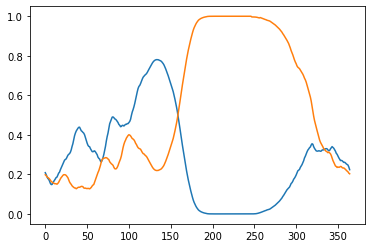

In [13]:
c = 20
arr = arraySMost[:,:,c]
m = arr.mean(axis=1)
plt.plot(m)
arr = arrayRFost[:,:,c]
m = arr.mean(axis=1)
plt.plot(m)

In [14]:
def meanContributingProprotion(array):
    meanArray = []
    for c in range(array.shape[2]):
        arr = array[:,:,c]
        m = arr.mean(axis=1)
        meanArray.append(m)
    return np.array(meanArray)

## Separate

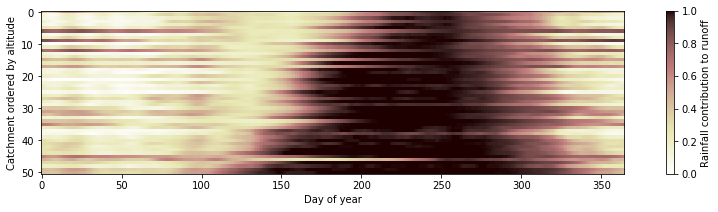

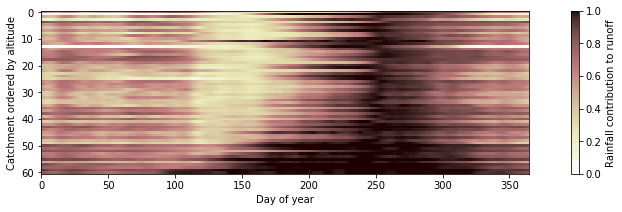

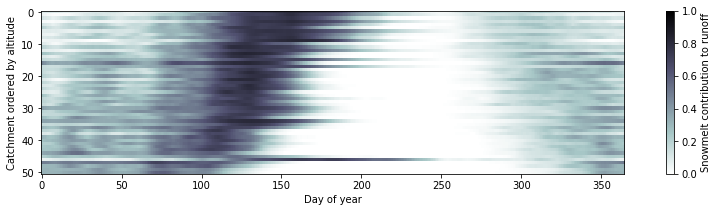

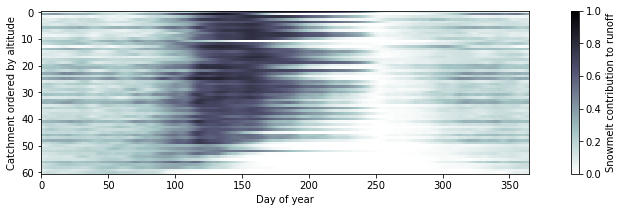

In [15]:
res = meanContributingProprotion(arrayRFost)
plt.figure(figsize=(15,3))
plt.imshow(res,vmin=0,vmax=1,cmap="pink_r", aspect = 2)
plt.colorbar(label="Rainfall contribution to runoff")
plt.xlabel("Day of year")
plt.ylabel("Catchment ordered by altitude")
plt.savefig("Plots/1983_2012/meanContributingProportion_rainfall_ost_1983_2012.png",dpi=400,bbox_inches='tight')

res = meanContributingProprotion(arrayRFvest)
plt.figure(figsize=(15,3))
plt.imshow(res,vmin=0,vmax=1,cmap="pink_r", aspect = 2)
plt.colorbar(label="Rainfall contribution to runoff")
plt.xlabel("Day of year")
plt.ylabel("Catchment ordered by altitude")
plt.savefig("Plots/1983_2012/meanContributingProportion_rainfall_vest_1983_2012.png",dpi=400,bbox_inches='tight')

res = meanContributingProprotion(arraySMost)
plt.figure(figsize=(15,3))
plt.imshow(res,vmin=0,vmax=1,cmap="bone_r", aspect = 2)
plt.colorbar(label="Snowmelt contribution to runoff")
plt.xlabel("Day of year")
plt.ylabel("Catchment ordered by altitude")
plt.savefig("Plots/1983_2012/meanContributingProportion_snowmelt_ost_1983_2012.png",dpi=400,bbox_inches='tight')

res = meanContributingProprotion(arraySMvest)
plt.figure(figsize=(15,3))
plt.imshow(res,vmin=0,vmax=1,cmap="bone_r", aspect = 2)
plt.colorbar(label="Snowmelt contribution to runoff")
plt.xlabel("Day of year")
plt.ylabel("Catchment ordered by altitude")
plt.savefig("Plots/1983_2012/meanContributingProportion_snowmelt_vest_1983_2012.png",dpi=400,bbox_inches='tight')

## Classified

In [16]:
RFcontOst = meanContributingProprotion(arrayRFost)
SMcontOst = meanContributingProprotion(arraySMost)

RFcontVest = meanContributingProprotion(arrayRFvest)
SMcontVest = meanContributingProprotion(arraySMvest)

RFcontNord = meanContributingProprotion(arrayRFnord)
SMcontNord = meanContributingProprotion(arraySMnord)

RFcontSor = meanContributingProprotion(arrayRFsor)
SMcontSor = meanContributingProprotion(arraySMsor)

RFcontFinn = meanContributingProprotion(arrayRFfinn)
SMcontFinn = meanContributingProprotion(arraySMfinn)

RFcontTrond = meanContributingProprotion(arrayRFtrond)
SMcontTrond = meanContributingProprotion(arraySMtrond)

In [17]:
def combinedContribution(RF,SM,domlim = 2/3):
    """
    Classifies the main contribution to runoff on each day in array.
    
    Arguments
    ---------
    RF: mean proportion of runoff contributed by rainfall
    SM: mean proportion of runoff contributed by snowmelt
    domlim: int
        Limit for deciding if which input is dominiant in runoff
    
    Returns
    -------
    array
    """
    
    Ncatch,Ndoy = RF.shape
    array = np.full_like(RF,np.nan)
    for c in range(Ncatch):
        for doy in range(Ndoy):
            r = RF[c,doy]
            s = SM[c,doy]
            
            # neither rainfall nor snowmelt is dominant
            if 1-(r+s)>domlim:
                array[c,doy]=0
            # rainfall is dominant   
            elif r>=domlim:
                array[c,doy]=1
            # snowmelt is dominant
            elif s>=domlim:
                array[c,doy]=3
            else:
                array[c,doy]=2

    return array

In [18]:
cmap = mpl.colors.ListedColormap(["w", "royalblue", "moccasin", "mediumseagreen"])
cmap = mpl.colors.ListedColormap(["lightgrey", "steelblue", "moccasin", "indianred"])

labels = {0:"Baseflow",
          1:"Rainfall",
          2:"Mixed",
          3:"Snowmelt"}

In [105]:
def plotClassifiedContribution(array,title=None,subplotting=False,ax=None,colorbar = True):
    # height of array
    N = array.shape[0]
    
    if subplotting:
        # figure
        cax = ax.imshow(array,aspect=3.5,cmap=cmap,vmin=-0.5,vmax=3.5)

        # labels
        ax.set_title(title,loc="right")
        #ax.set_xlabel("DOY")
        ax.set_ylabel("Catchments by altitude")
        
        # colorbar
        if colorbar:
            cbar = fig.colorbar(cax, ax=ax)
            cbar.ax.set_yticklabels(labels.values())
            cbar.set_label(label="Dominant source \nof streamflow",weight="bold")
        return cax

    else:
        # figure
        plt.figure(figsize=(12,N/23))
        plt.imshow(array,aspect=3.5,cmap=cmap,vmin=-0.5,vmax=3.5)

        # labels
        plt.title(title,loc="right")
        plt.xlabel("DOY")
        plt.ylabel("Catchments by altitude")

        # colorbar
        cbar = plt.colorbar()
        cbar.ax.set_yticklabels(labels.values())
        cbar.set_label(label="Dominant source \nof streamflow",weight="bold")

/home/skalevag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


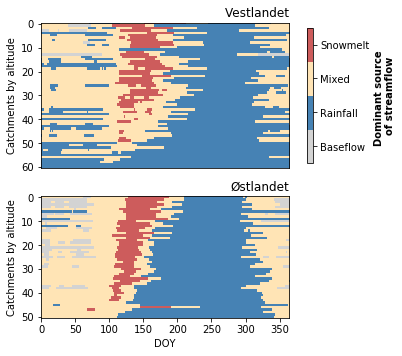

In [122]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(5,5))
gs = GridSpec(2, 1, height_ratios=[61, 51])

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

plotClassifiedContribution(combinedContribution(RFcontVest,SMcontVest),subplotting=True,ax=ax1,title="Vestlandet",colorbar=False)
ax1.set_xticks([],[])
ax2.set_xlabel("DOY")
cax = plotClassifiedContribution(combinedContribution(RFcontOst,SMcontOst),subplotting=True,ax=ax2,title="Østlandet",colorbar=False)

cbar = fig.colorbar(cax, ax=[ax1,ax2],shrink=0.5,anchor=(2.4,1.1))
cbar.ax.set_yticklabels(labels.values())
cbar.set_label(label="Dominant source \nof streamflow",weight="bold")

plt.tight_layout()
plt.savefig("Paper and poster/meanContributingProportion.png",dpi=600,bbox_inches='tight')

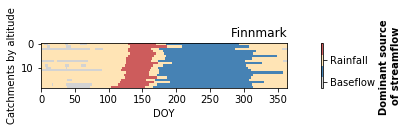

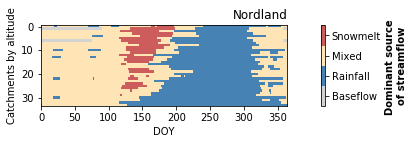

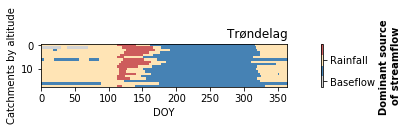

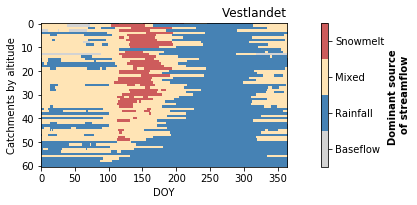

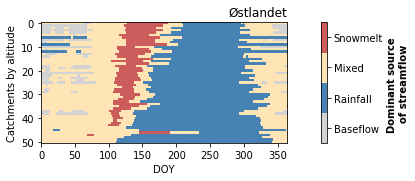

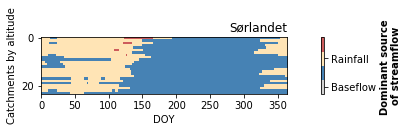

In [30]:
plotClassifiedContribution(combinedContribution(RFcontFinn,SMcontFinn),title="Finnmark")
plt.savefig("Plots/1983_2012/meanContributingProportion_finn_1983_2012.png",dpi=400,bbox_inches='tight')

plotClassifiedContribution(combinedContribution(RFcontNord,SMcontNord),title="Nordland")
plt.savefig("Plots/1983_2012/meanContributingProportion_nord_1983_2012.png",dpi=400,bbox_inches='tight')

plotClassifiedContribution(combinedContribution(RFcontTrond,SMcontTrond),title="Trøndelag")
plt.savefig("Plots/1983_2012/meanContributingProportion_trond_1983_2012.png",dpi=400,bbox_inches='tight')

plotClassifiedContribution(combinedContribution(RFcontVest,SMcontVest),title="Vestlandet")
plt.savefig("Plots/1983_2012/meanContributingProportion_vest_1983_2012.png",dpi=400,bbox_inches='tight')

plotClassifiedContribution(combinedContribution(RFcontOst,SMcontOst),title="Østlandet")
plt.savefig("Plots/1983_2012/meanContributingProportion_ost_1983_2012.png",dpi=400,bbox_inches='tight')

plotClassifiedContribution(combinedContribution(RFcontSor,SMcontSor),title="Sørlandet")
plt.savefig("Plots/1983_2012/meanContributingProportion_sor_1983_2012.png",dpi=400,bbox_inches='tight')

# Initial plots of results

In [ ]:
def plotContributingProprotion(sign,mag,name,save=True,cmap="PuOr"):
    for c in range(mag.shape[0]):
        plt.plot(mag[c,:])

    plt.figure(figsize=(10,mag.shape[0]/25))
    plt.imshow(mag,cmap=cmap,aspect=2,vmin=-0.025,vmax=0.025)
    plt.colorbar(label=f"{name[:8].upper()} \ncontribution trend")
    plt.xlabel("Day of year")
    plt.ylabel("Catchment by altitude")
    if save:
        plt.savefig(f"Plots/1983_2012/dailyTrend_{name}.png",dpi=400,bbox_inches='tight')

    plt.figure(figsize=(10,3))
    plt.imshow(sign,cmap="Blues",aspect=2)
    plt.xlabel("Day of year")
    plt.colorbar()

    np.place(mag,sign==0,np.nan)
    plt.figure(figsize=(10,mag.shape[0]/25))
    plt.xlabel("Day of year")
    plt.imshow(mag,cmap=cmap,aspect=2,vmin=-0.025,vmax=0.025)
    plt.colorbar(label=f"{name[:8].upper()} \ncontribution trend")

    plt.figure()
    for c in range(mag.shape[0]):
        plt.plot(mag[c,:])
    plt.xlabel("Day of year")

## Ostlandet

### Snowmelt contribution

In [ ]:
sign = np.load("Results/Daily/trendSignificance_snowmeltContRunoff_ost_10dMA_1983_2012.npy")
mag = np.load("Results/Daily/trendMagnitudes_snowmeltContRunoff_ost_10dMA_1983_2012.npy")
name = "snowmeltContRunoff_ost_10dMA_1983_2012"

plotContributingProprotion(sign,mag,name)

Comments...

### Rainfall contribution

In [ ]:
sign = np.load("Results/Daily/trendSignificance_rainfallContRunoff_ost_10dMA_1983_2012.npy")
mag = np.load("Results/Daily/trendMagnitudes_rainfallContRunoff_ost_10dMA_1983_2012.npy")
name = "rainfallContRunoff_ost_10dMA_1983_2012"

plotContributingProprotion(sign,mag,name,cmap="BrBG")

Comments...

## Vestlandet

### Rainfall contribution

In [ ]:
sign = np.load("Results/Daily/trendSignificance_rainfallContRunoff_vest_10dMA_1983_2012.npy")
mag = np.load("Results/Daily/trendMagnitudes_rainfallContRunoff_vest_10dMA_1983_2012.npy")
name = "rainfallContRunoff_vest_10dMA_1983_2012"

plotContributingProprotion(sign,mag,name,cmap="BrBG")

Comments...

### Snowmelt contribution

In [ ]:
sign = np.load("Results/Daily/trendSignificance_snowmeltContRunoff_vest_10dMA_1983_2012.npy")
mag = np.load("Results/Daily/trendMagnitudes_snowmeltContRunoff_vest_10dMA_1983_2012.npy")
name = "snowmeltContRunoff_vest_10dMA_1983_2012"

plotContributingProprotion(sign,mag,name)

Comments...

## Nordland

### Snowmelt contribution

In [ ]:
region = "nord"
sign = np.load(f"Results/Daily/trendSignificance_snowmeltContRunoff_{region}_10dMA_1983_2012.npy")
mag = np.load(f"Results/Daily/trendMagnitudes_snowmeltContRunoff_{region}_10dMA_1983_2012.npy")
name = f"snowmeltContRunoff_{region}_10dMA_1983_2012"

plotContributingProprotion(sign,mag,name)

Comments...

### Rainfall contribution

In [ ]:
sign = np.load(f"Results/Daily/trendSignificance_rainfallContRunoff_{region}_10dMA_1983_2012.npy")
mag = np.load(f"Results/Daily/trendMagnitudes_rainfallContRunoff_{region}_10dMA_1983_2012.npy")
name = f"rainfallContRunoff_{region}_10dMA_1983_2012"

plotContributingProprotion(sign,mag,name,cmap="BrBG")

Comments...

## Trøndelag

### Snowmelt contribution

In [ ]:
region = "trond"
sign = np.load(f"Results/Daily/trendSignificance_snowmeltContRunoff_{region}_10dMA_1983_2012.npy")
mag = np.load(f"Results/Daily/trendMagnitudes_snowmeltContRunoff_{region}_10dMA_1983_2012.npy")
name = f"snowmeltContRunoff_{region}_10dMA_1983_2012"

plotContributingProprotion(sign,mag,name)

Comments...

### Rainfall contribution

In [ ]:
sign = np.load(f"Results/Daily/trendSignificance_rainfallContRunoff_{region}_10dMA_1983_2012.npy")
mag = np.load(f"Results/Daily/trendMagnitudes_rainfallContRunoff_{region}_10dMA_1983_2012.npy")
name = f"rainfallContRunoff_{region}_10dMA_1983_2012"

plotContributingProprotion(sign,mag,name,cmap="BrBG")

Comments...

## Sørlandet

### Snowmelt contribution

In [ ]:
region = "sor"
sign = np.load(f"Results/Daily/trendSignificance_snowmeltContRunoff_{region}_10dMA_1983_2012.npy")
mag = np.load(f"Results/Daily/trendMagnitudes_snowmeltContRunoff_{region}_10dMA_1983_2012.npy")
name = f"snowmeltContRunoff_{region}_10dMA_1983_2012"

plotContributingProprotion(sign,mag,name)

Comments...

### Rainfall contribution

In [ ]:
sign = np.load(f"Results/Daily/trendSignificance_rainfallContRunoff_{region}_10dMA_1983_2012.npy")
mag = np.load(f"Results/Daily/trendMagnitudes_rainfallContRunoff_{region}_10dMA_1983_2012.npy")
name = f"rainfallContRunoff_{region}_10dMA_1983_2012"

plotContributingProprotion(sign,mag,name,cmap="BrBG")

Comments...

## Finnmark

### Snowmelt contribution

In [ ]:
region = "finn"
sign = np.load(f"Results/Daily/trendSignificance_snowmeltContRunoff_{region}_10dMA_1983_2012.npy")
mag = np.load(f"Results/Daily/trendMagnitudes_snowmeltContRunoff_{region}_10dMA_1983_2012.npy")
name = f"snowmeltContRunoff_{region}_10dMA_1983_2012"

plotContributingProprotion(sign,mag,name)

Comments...

### Rainfall contribution

In [ ]:
sign = np.load(f"Results/Daily/trendSignificance_rainfallContRunoff_{region}_10dMA_1983_2012.npy")
mag = np.load(f"Results/Daily/trendMagnitudes_rainfallContRunoff_{region}_10dMA_1983_2012.npy")
name = f"rainfallContRunoff_{region}_10dMA_1983_2012"

plotContributingProprotion(sign,mag,name,cmap="BrBG")

Comments...